# "DEEP VISION CROWD MONITOR : AI FOR DENSITY ESTIMATION AND OVERCROWDING DETECTION"


>> Data Exploration & Preprocessing*


>> In this notebook, I explore the ShanghaiTech Part A dataset and perform preprocessing steps required for crowd counting.

>> This includes:

- Visualizing sample images  
- Extracting head-point annotations  
- Generating both fixed Gaussian density maps & adaptive (KNN-based) density maps  
- Full preprocessing
- View 5 random samples
- Pytorch Dataset + DataLoader

In [ ]:
#import necessary libraries

import os
import cv2
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [4]:
# ---------- Paths ----------
img_path = r"C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\images"
gt_path = r"C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\ground-truth"

Image file: C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\images\IMG_1.jpg


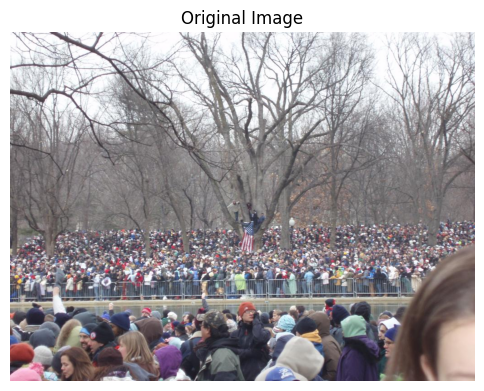

In [ ]:
# ---------- Load first image ----------

img_files = [f for f in os.listdir(img_path) if f.endswith(('.jpg','.jpeg','.png'))]

if len(img_files) == 0:
    print("No images found!")
else:
    img_name = img_files[0]
    img_full = os.path.join(img_path, img_name)

    print("Image file:", img_full)

    # load the image
    img = cv2.imread(img_full)
    if img is None:
        print(f"Error: Could not read image from {img_full}")
        raise ValueError("Image failed to load")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #converts bgr to rgb
   
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()


In [6]:
# ---------- Ground truth Annotations Visualization ----------
mat_name = "GT_" + img_name.replace(".jpg", ".mat").replace(".png",".mat")
mat_full = os.path.join(gt_path, mat_name)

print("MAT file path:", mat_full)

MAT file path: C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_1.mat


In [7]:
 # ---------- Load MAT file ----------
try:
        mat = scipy.io.loadmat(mat_full)
        print("Loaded MAT file successfully")
except Exception as e:
        print("Error reading MAT file:", e)
        raise

Loaded MAT file successfully


In [8]:
# ---------- Extract head points ----------
try:
        points = mat["image_info"][0][0][0][0][0]
        print("Number of annotated points:", len(points))
except:
        print("Failed to extract points. Let's inspect keys:", mat.keys())
        raise

Number of annotated points: 1546


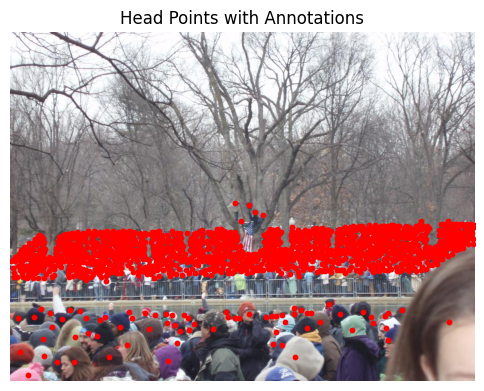

In [9]:
# ---------- Plot image + red points ----------
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.scatter(points[:,0], points[:,1], s=10, color='red')
plt.title("Head Points with Annotations")
plt.axis("off")
plt.show()

Image shape: (768, 1024)
Number of annotated heads: 1546
Sum before blurring (should equal N): 1546.0


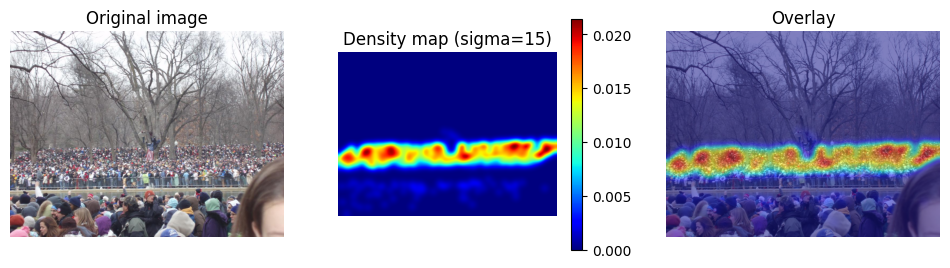

Sum after blurring (should still be ~N): 1546.0002


In [10]:
# ---------- Create density map using fixed sigma----------

H, W = img.shape[0], img.shape[1] # height, width
print("Image shape:", (H, W))
print("Number of annotated heads:", len(points))

# 1) Create empty density map (float32)
density = np.zeros((H, W), dtype=np.float32)

# 2) Put 1 at each head location
# points are [x, y] where x is horizontal, y is vertical.
for (x, y) in points:
    xi = int(round(x))
    yi = int(round(y))
    # boundary check (in case a point sits on the very edge)
    if 0 <= yi < H and 0 <= xi < W:
        density[yi, xi] += 1.0

# Quick sanity: sum should equal number of points
print("Sum before blurring (should equal N):", density.sum())

# 3) Apply Gaussian smoothing 
sigma = 15    # controls spread; -- fixed sigma
density_blurred = gaussian_filter(density, sigma=sigma)

# 4) Visualize 
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(density_blurred, cmap='jet')
plt.title(f"Density map (sigma={sigma})")
plt.colorbar(shrink=0.6)
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(density_blurred, cmap='jet', alpha=0.5)   # overlay
plt.title("Overlay")
plt.axis("off")

plt.show()

print("Sum after blurring (should still be ~N):", density_blurred.sum())

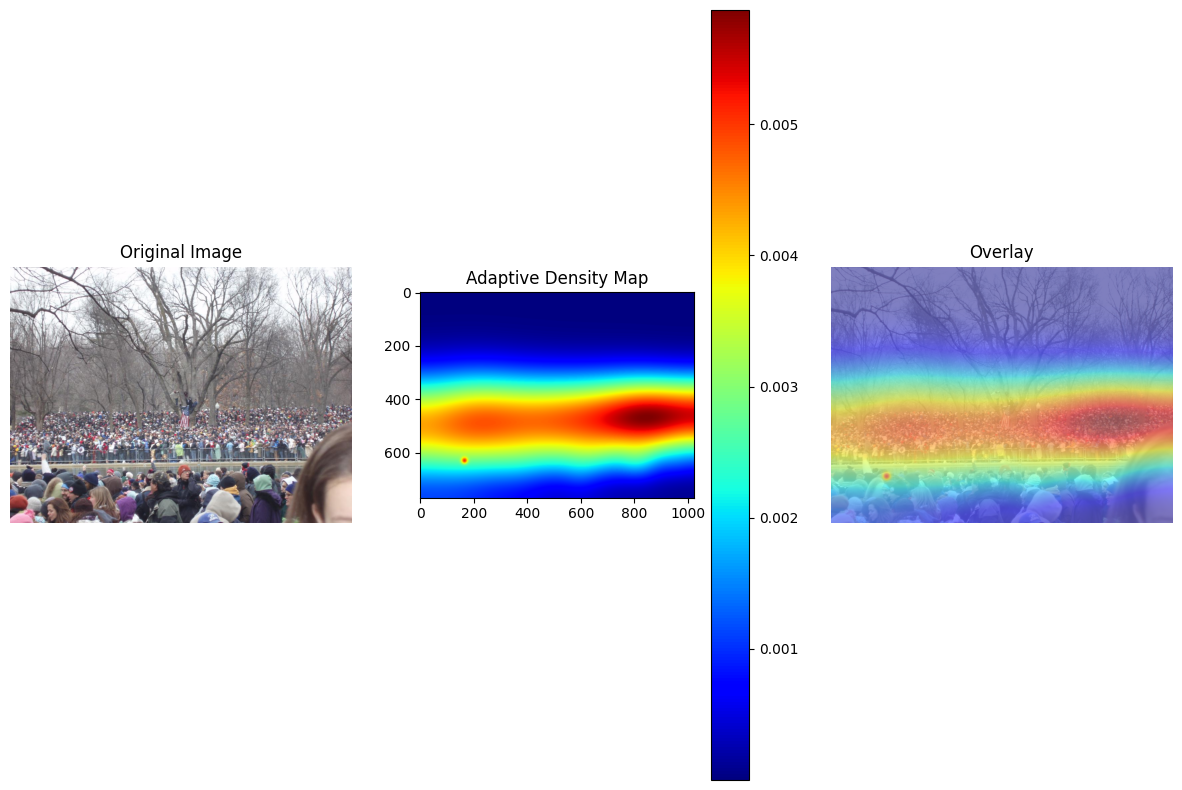

Sum after blurring (should still be ~N): 1536.3704


In [ ]:
# ---------- Create density map using Adaptive sigma----------  (OPTIONAL)

from scipy.spatial import KDTree
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

def adaptive_density(img_shape, points, k=3, std_scale=0.3):
    h, w = img_shape[0], img_shape[1]
    density = np.zeros((h, w), dtype="float32")

    if len(points) == 0:
        print("⚠ No points found")
        return density

    if len(points) == 1:
        print("⚠ Only one point → Using fixed sigma=15")
        x, y = int(points[0][0]), int(points[0][1])
        density[y, x] = 1
        return gaussian_filter(density, sigma=15)

    # KNN + adaptive sigma
    tree = KDTree(points)

    for p in points:
        distances, _ = tree.query(p, k=min(k+1, len(points)))
        sigma = std_scale * np.mean(distances[1:])

        x, y = int(p[0]), int(p[1])
        density[y, x] = 1

        density = gaussian_filter(density, sigma=sigma)
       
    return density

# ----- Generate density -----
density = adaptive_density(img.shape, points)

# ----- Plot -----
plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(density, cmap='jet')
plt.title("Adaptive Density Map")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(img, alpha=0.5)
plt.imshow(density, cmap='jet', alpha=0.5)
plt.title("Overlay")
plt.axis("off")

plt.show()

density_blurred = gaussian_filter(density, sigma=sigma)
print("Sum after blurring (should still be ~N):", density_blurred.sum())


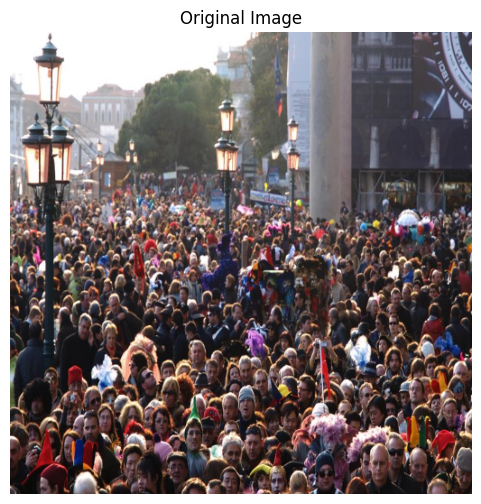

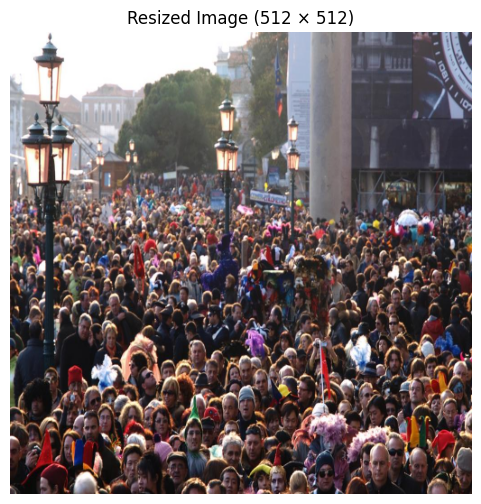

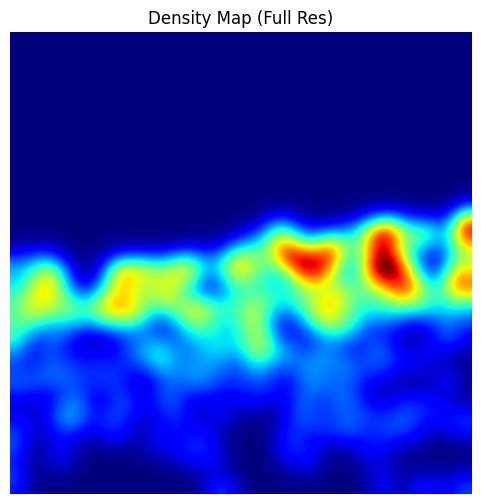

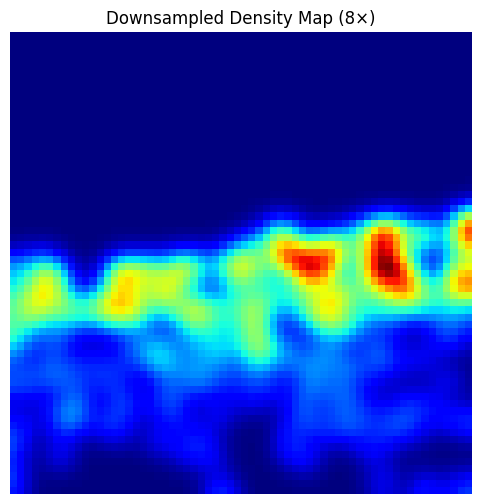

Image Tensor: torch.Size([3, 512, 512])
Density Tensor: torch.Size([64, 64])


In [ ]:
                                   # ---------- Full Preprocessing Pipeline for one image ----------                            

import os
import cv2
import numpy as np
import scipy.io
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Image (RGB)
# -----------------------------
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # BGR → RGB
    img = img.astype("float32") / 255.0          # Scale 0–1
    return img

# -----------------------------
# 2. Resize Image
# -----------------------------
def resize_image(img, size=(512, 512)): 
    return cv2.resize(img, size)
    

# -----------------------------
# 3. Normalize Image (ImageNet)
# -----------------------------
def normalize_image(img):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    norm_img = (img - mean) / std
    return norm_img, mean, std

# -----------------------------
# 4. Load Ground-Truth Points
# -----------------------------
def load_points(gt_path):
    mat = scipy.io.loadmat(gt_path)
    points = mat["image_info"][0][0][0][0][0]
    return points

# -----------------------------
# 5. Create Density Map (fixed sigma)
# -----------------------------
def create_density(img_shape, points, sigma=15):
    h, w = img_shape[0], img_shape[1]

    density = np.zeros((h, w), dtype=np.float32)

    for x, y in points:
        x, y = int(x), int(y)
        if 0 <= x < w and 0 <= y < h:
            density[y, x] += 1.0

    density = gaussian_filter(density, sigma=sigma)
    return density

# -----------------------------
# 6. Downsample Density Map by 8×
# -----------------------------
def downsample_density(density, factor=8):
    h, w = density.shape
    new_h, new_w = h // factor, w // factor
    d8 = cv2.resize(density, (new_w, new_h), interpolation=cv2.INTER_AREA)
    d8 *= factor * factor  # multiply by 64
    return d8

# -----------------------------
# 7. Convert to Torch Tensors
# -----------------------------
def to_tensor(norm_img, density_8x):
    img_tensor = torch.tensor(norm_img.transpose(2, 0, 1), dtype=torch.float32)
    gt_tensor = torch.tensor(density_8x, dtype=torch.float32)
    return img_tensor, gt_tensor


# -----------------------------
# 8. Run Full Pipeline on 1 Image
# -----------------------------
img_path = r"C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\images\IMG_2.jpg"
gt_path  = r"C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_2.mat"

# Step-by-step preprocessing
img = load_image(img_path)
resized = resize_image(img)
norm_img, mean, std = normalize_image(resized)
points = load_points(gt_path)

density = create_density(resized.shape, points)
density_8x = downsample_density(density)

img_tensor, gt_tensor = to_tensor(norm_img, density_8x)

# -----------------------------
# 9. Display Everything
# -----------------------------
plt.figure(figsize=(6,6))
plt.title("Original Image")
plt.imshow(resized)
plt.axis("off")
plt.show()

plt.figure(figsize=(6,6))
plt.title("Resized Image (512 × 512)")
plt.imshow(resized_img)
plt.axis("off")
plt.show()

plt.figure(figsize=(6,6))
plt.title("Density Map (Full Res)")
plt.imshow(density, cmap="jet")
plt.axis("off")
plt.show()

plt.figure(figsize=(6,6))
plt.title("Downsampled Density Map (8×)")
plt.imshow(density_8x, cmap="jet")
plt.axis("off")
plt.show()

print("Image Tensor:", img_tensor.shape)
print("Density Tensor:", gt_tensor.shape)

In [ ]:
                    # ---------- Full Preprocessing Pipeline for ALL images ----------



for i, img_name in enumerate(tqdm(img_files)):

    # --- Load image ---
    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 🔥 IMPORTANT: resize to fixed size BEFORE normalization
    img = cv2.resize(img, (512, 512))

    # --- Normalize ---
    img_tensor = transform(img)

    # --- Load Ground Truth ---
    mat_name = "GT_" + img_name.replace(".jpg", ".mat")
    mat_path = os.path.join(gt_dir, mat_name)
    mat = scipy.io.loadmat(mat_path)
    points = mat["image_info"][0][0][0][0][0]

    # --- Density Map (same code) ---
    H, W = img.shape[:2]
    density = np.zeros((H, W), dtype=np.float32)

    for (x, y) in points:
        x, y = int(x * (512 / W)), int(y * (512 / H))  #  scale points if resizing!
        if 0 <= x < 512 and 0 <= y < 512:
            density[y, x] += 1.0

    density = gaussian_filter(density, sigma=15)

    # ---- Downsample (8x) ----
    density_8x = cv2.resize(density, (512//8, 512//8), interpolation=cv2.INTER_AREA)
    density_8x *= 64

    gt_tensor = torch.tensor(density_8x, dtype=torch.float32)


    os.makedirs(save_img_tensor, exist_ok=True)
    os.makedirs(save_gt_tensor, exist_ok=True)

    # SAVE (same)
    torch.save(img_tensor, os.path.join(save_img_tensor, img_name.replace(".jpg", ".pt")))
    torch.save(gt_tensor, os.path.join(save_gt_tensor, img_name.replace(".jpg", ".pt")))

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:36<00:00,  8.27it/s]


Showing these 5 samples:
['IMG_100.jpg_plot.png', 'IMG_101.jpg_plot.png', 'IMG_102.jpg_plot.png', 'IMG_1.jpg_plot.png', 'IMG_10.jpg_plot.png']


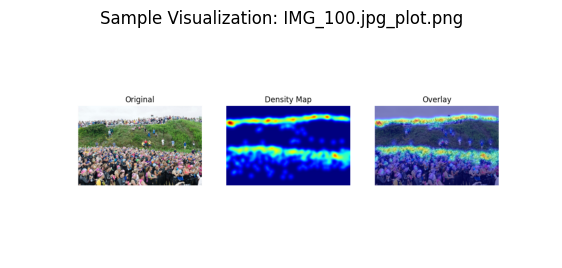

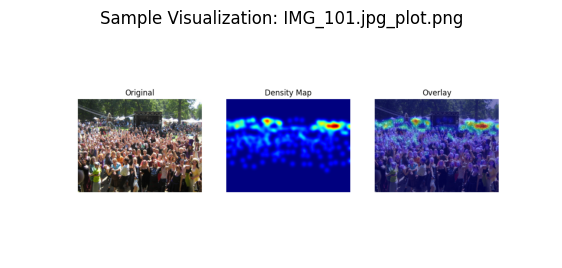

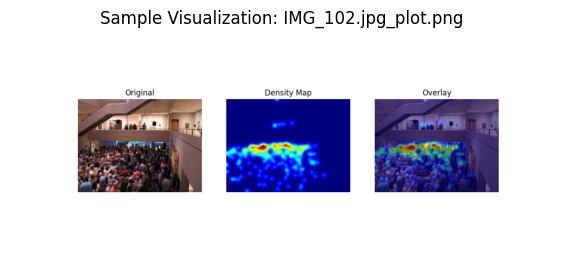

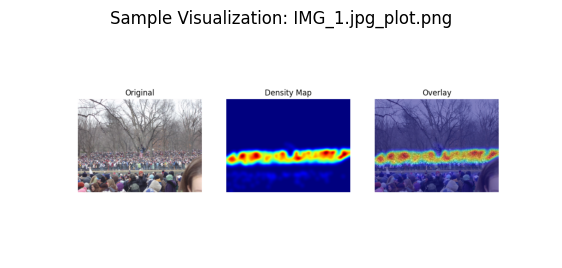

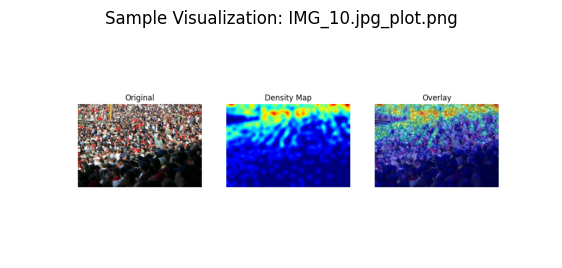

In [ ]:
                            # ---------- View 5 Random Sample Visualizations ----------

import matplotlib.pyplot as plt
import random
import os
import numpy as np

# Folder where you saved visualizations (change if needed)
save_folder = r"C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\processed\plots"

# Get all saved plot files
files = [f for f in os.listdir(save_folder) if f.endswith(".png")]

# Pick 5 random samples
sample_files = random.sample(files, 5)

print("Showing these 5 samples:")
print(sample_files)

for file in sample_files:
    img_path = os.path.join(save_folder, file)
    img = plt.imread(img_path)

    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.title(f"Sample Visualization: {file}")
    plt.axis("off")
    plt.show()

In [ ]:
                                    # ---------- Pytorch Dataset + DataLoader ----------    

from torch.utils.data import Dataset, DataLoader
import os
import torch

class CrowdDataset(Dataset):
    def __init__(self, img_tensor_folder, gt_tensor_folder):
        """
        img_tensor_folder : path to folder containing image .pt tensors
        gt_tensor_folder  : path to folder containing density .pt tensors
        """
        self.img_folder = img_tensor_folder
        self.gt_folder  = gt_tensor_folder

        # list all .pt image tensors
        self.files = sorted([f for f in os.listdir(self.img_folder) if f.endswith(".pt")])

        if len(self.files) == 0:
            raise ValueError("No .pt files found! Did preprocessing run correctly?")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]               # e.g., "IMG_1.pt"
        
        # full file paths
        img_path = os.path.join(self.img_folder, img_name)
        gt_path  = os.path.join(self.gt_folder,  img_name)

        # load tensors
        img_tensor = torch.load(img_path)        # shape: [3, 512, 512]
        gt_tensor  = torch.load(gt_path)         # shape: [64, 64]

        return img_tensor, gt_tensor


# -------------------------------
# Create dataset + dataloader
# -------------------------------
DatasetA = CrowdDataset(
    img_tensor_folder="processed/images_tensor",
    gt_tensor_folder="processed/density_tensor"
)

DataloaderA = DataLoader(
    DatasetA,
    batch_size=4,
    shuffle=True
)

print("Dataset size:", len(DatasetA))

# -------------------------------
# Test one batch
# -------------------------------
for imgs, gts in DataloaderA:
    print("Batch image tensor shape:", imgs.shape)
    print("Batch density tensor shape:", gts.shape)
    break

Dataset size: 300
Batch image tensor shape: torch.Size([4, 3, 512, 512])
Batch density tensor shape: torch.Size([4, 64, 64])
